### Aim of notebook: 
Create classifier to predict the "grade" and "bog" labels based on the "terrain" description for the hikes listed on the walkhighlands website


1) Import modules

In [144]:
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix 
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns



2) Load JSON data, and analyse input data

In [23]:
with open('/Users/kirstentempest/Private_projects/walkhighlands_scraper/walkhighlands_scraper/walks.json') as f:
    data = json.load(f) # load json file 
df = pd.DataFrame(data) # convert to pandas DataFrame
print(df.head(5)) # print first 5 entries 

                                name  \
0       Beinn Tharsuinn, near Alness   
1  Tarbat Ness circuit, Portmahomack   
2         Struie Hill, near Edderton   
3       Fyrish Monument, near Alness   
4               River Averon, Alness   

                                                 url  grade  bog  \
0  https://www.walkhighlands.co.uk/ullapool/beinn...      4    4   
1  https://www.walkhighlands.co.uk/ullapool/tarba...      2    3   
2  https://www.walkhighlands.co.uk/ullapool/strui...      2    2   
3  https://www.walkhighlands.co.uk/ullapool/fyris...      1    2   
4  https://www.walkhighlands.co.uk/ullapool/river...      1    3   

                                             terrain  
0  Good track for approach, then very rough pathl...  
1  Mostly grassy shorelines. The outward section ...  
2  Tarred track at first, then hill track and pat...  
3  Good woodland path with a fair amount of up an...  
4  Clear paths, golf course and minor road, with ...  


Analyse data for: 
- missing values
- number of entries
- distribution of classifying variables

Missing values per column:
name                    0
url                     0
grade                   0
bog                     0
terrain                 0
terrain_length_chars    0
terrain_length_words    0
dtype: int64

Number of entries: 74


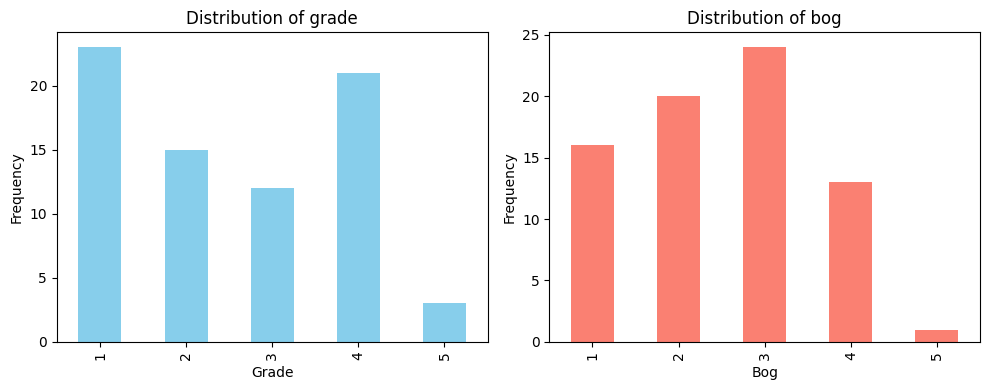

In [266]:
# 1) missing values
print("Missing values per column:")
print(df.isnull().sum())

# 2) number of entries
print("\nNumber of entries:", len(df))

# 3) distribution of 'grade' and 'bog'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

df['grade'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of grade')
axes[0].set_xlabel('Grade')
axes[0].set_ylabel('Frequency')

df['bog'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Distribution of bog')
axes[1].set_xlabel('Bog')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Calculate distribution of text length in "terrain" description 

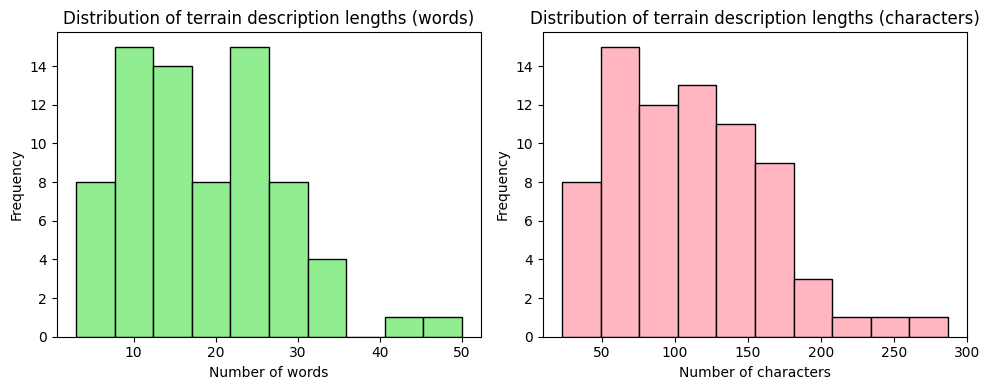

In [47]:
# add new column for terrain text length
df['terrain_length_chars'] = df['terrain'].apply(len) # count characters
df['terrain_length_words'] = df['terrain'].apply(lambda x: len(x.split())) # count words

# plot histograms
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(df['terrain_length_words'], bins=10, color='lightgreen', edgecolor='black')

axes[0].set_title('Distribution of terrain description lengths (words)')
axes[0].set_xlabel('Number of words')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['terrain_length_chars'], bins=10, color='lightpink', edgecolor='black')
axes[1].set_title('Distribution of terrain description lengths (characters)')
axes[1].set_xlabel('Number of characters')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

3) Preprocess text

   * Process text into numerical inputs for classifier.
   * BERT uses WordPiece tokenisation, breaking text into subword units.
   * Tokenize returns:
     + input_ids: The numerical token IDs for each word/subword
        - Prepares input in the format BERT expects: [CLS] ... [SEP] or [101, ..., 102] where CLS is the start of input and SEP the separator
     + token_type_ids (used for sentence-pair tasks, not needed here)
     + attention_mask: A binary mask (1 for real tokens, 0 for padding)
     

In [268]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # loads tokeniser

def tokenize(texts, max_length=100):
    tokenised_input = tokenizer(
        texts,
        padding=True, # ensures all inputs are same length, pads shorter descriptions
        truncation=True, # shortens descriptions longer than the max_length
        max_length=max_length, # max number of tokens
        return_tensors="pt" # outputs PyTorch tensors 
    )
    labels = df[['grade','bog']].values # converts to np array (needed to convert to tensors)
    return tokenised_input, labels
    

# Tokenize terrain
tokens, labels = tokenize(df['terrain'].tolist())

Example of tokenizer: 

In [273]:
tokenize("Steep and muddy hill")[0]

{'input_ids': tensor([[  101,  9561,  1998, 15405,  2940,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

4) create PyTorch dataset with tokenised data and labels

In [276]:
class TerrainDataset(Dataset):
    def __init__(self, tokens, labels):
        self.input_ids = tokens['input_ids'] # output of BERT tokeniser
        self.attention_mask = tokens['attention_mask']
        self.labels = torch.tensor(labels, dtype=torch.long) # converts to PyTorch tensor

    def __len__(self):
        return len(self.labels) # returns number of samples in dataset 

    def __getitem__(self, idx): # returns a single sample by index as a dictionary 
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

dataset = TerrainDataset(tokens, labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) # split data into train and test set 
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True) # load data into DataLoader to enable batching. Shuffle true incase there're learning patterns in data order
test_loader = DataLoader(test_dataset, batch_size=4)


5. Define model

Build a model that takes a text description of terrain as input, and predicts two continuous numeric values:
* grade (difficulty of hike)
* bog (wetness/bog factor)

In [278]:
class TerrainClassifier(nn.Module):
    def __init__(self, num_classes=5): # number of possible classes to be classified into 
        super().__init__() #calls the constructor of the parent class nn.Module
        self.bert = BertModel.from_pretrained('bert-base-uncased') # load pre-trained BERT model with original weights. Feature extractor layer.
        self.dropout = nn.Dropout(0.3) # dropout layer prevents overfitting, by randomnly zeroing 30% of outputs
        self.grade_head = nn.Linear(self.bert.config.hidden_size, num_classes) # fully connected (dense) layer. Linear maps the pooled BERT output (of hidden_size) to be classified into 5 possible categories.
        self.bog_head = nn.Linear(self.bert.config.hidden_size, num_classes) # Heads takes BERT's output and maps it onto a score.

    def forward(self, input_ids, attention_mask): # defines the forward pass, ie what happens when inputing data into the model. 
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output) # pooler_output is a summary vector of the description. 
        grade_logits = self.grade_head(pooled_output)
        bog_logits = self.bog_head(pooled_output)
        return grade_logits, bog_logits # shape: [batch_size, 5]

# next use CrossEntropyLoss to apply Softmax internally and compute how close your prediction is to the correct class


6. Train model 

In [304]:
# Set up model, loss, and optimizer
model = TerrainClassifier(num_classes=5) # instantiates classification model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device) # moves model to the selected device for computation

criterion = nn.CrossEntropyLoss() # loss function, used for multi-class classification. Internally applies LogSoftmax + NLLLoss.
optimizer = optim.Adam(model.parameters(), lr=2e-5) # updates all trainable parameters using Adam optimiser. lr = learning rate. 

# Training loop
epochs = 11 # how many times the model will see the entire training dataset 

for epoch in range(epochs):
    model.train() # training mode
    total_loss = 0 # keep track of cumulative loss for the epoch 

    for batch in tqdm(train_loader): #iterates over batches from the training set using a progress bar.
        input_ids = batch['input_ids'].to(device) # moves input data and labels to the same device as the model (GPU or CPU).
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)  # shape: (batch_size, 2)

        grade_labels = labels[:, 0]-1 # PyTorch classes zero-indexed
        bog_labels = labels[:, 1]-1

        optimizer.zero_grad() #clears old gradients from previous step
        grade_logits, bog_logits = model(input_ids, attention_mask) # runs the forward pass

        loss_grade = criterion(grade_logits, grade_labels) # calculates cross-entropy loss for each target separately
        loss_bog = criterion(bog_logits, bog_labels)
        loss = loss_grade + loss_bog

        loss.backward() # performs backpropagation 
        optimizer.step() # updates model weights using gradients computed during backpropagation
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:28<00:00,  1.90s/it]


Epoch 1 | Loss: 47.8643


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:28<00:00,  1.88s/it]


Epoch 2 | Loss: 42.7539


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:25<00:00,  1.72s/it]


Epoch 3 | Loss: 41.8892


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:30<00:00,  2.03s/it]


Epoch 4 | Loss: 36.8594


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:28<00:00,  1.89s/it]


Epoch 5 | Loss: 33.1347


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:26<00:00,  1.75s/it]


Epoch 6 | Loss: 29.4354


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:26<00:00,  1.78s/it]


Epoch 7 | Loss: 23.1504


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:27<00:00,  1.84s/it]


Epoch 8 | Loss: 20.7715


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:28<00:00,  1.92s/it]


Epoch 9 | Loss: 17.9337


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:27<00:00,  1.84s/it]


Epoch 10 | Loss: 16.5516


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:27<00:00,  1.82s/it]

Epoch 11 | Loss: 14.3156


7. Evaluate model 

In [306]:
model.eval() # put model in evaluation mode

# storage for predictions and true labels
all_grade_preds, all_bog_preds = [], []
all_grade_labels, all_bog_labels = [], []

with torch.no_grad(): # turn off gradient tracking for evaluation
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        grade_labels = labels[:, 0]-1  # separate grade and bog labels
        bog_labels = labels[:, 1]-1

        grade_logits, bog_logits = model(input_ids, attention_mask)  # forward pass

        grade_preds = torch.argmax(grade_logits, dim=1) # argmax finds the index of the highest score (i.e., predicted class) e.g. if the logits are [0.2, 0.1, 2.0, 0.4, 0.3], argmax is 2.
        bog_preds = torch.argmax(bog_logits, dim=1)

        # Store predictions and true labels
        all_grade_preds.extend(grade_preds.cpu().numpy()) # moves data to CPU, converts to np, and stores it.
        all_bog_preds.extend(bog_preds.cpu().numpy())
        all_grade_labels.extend(grade_labels.cpu().numpy())
        all_bog_labels.extend(bog_labels.cpu().numpy())

# Define full set of class indices (0 to 4, corresponding to original labels 1 to 5)
class_labels = [0, 1, 2, 3, 4]
class_names = [str(i) for i in range(1, 6)]  # for display purposes

# Print classification reports
print("Classification report info:")
print("Precision = Of all predictions the model made for a given class, how many were actually correct?, TP / (TP + FP)")
print("Recall = Of all actual samples of a given class, how many did the model correctly identify?, Formula: TP / (TP + FN)")
print("f1-score = Harmonic mean of precision and recall, balances both")
print("Support = How many true samples of this class were present in the dataset?")
print("Accuracy = Overall percentage of correct predictions")
print("macro avg = Average of precision, recall, and f1-score across all classes equally weighted")
print("weighted avg = Average of metrics weighted by support (number of instances per class)")


print("📊 Grade Classification Report:")
print(classification_report(all_grade_labels, all_grade_preds, labels=class_labels, target_names=class_names))

print("\n📊 Bog Classification Report:")
print(classification_report(all_bog_labels, all_bog_preds, labels=class_labels, target_names=class_names))


Classification report info:
Precision = Of all predictions the model made for a given class, how many were actually correct?, TP / (TP + FP)
Recall = Of all actual samples of a given class, how many did the model correctly identify?, Formula: TP / (TP + FN)
f1-score = Harmonic mean of precision and recall, balances both
Support = How many true samples of this class were present in the dataset?
Accuracy = Overall percentage of correct predictions
macro avg = Average of precision, recall, and f1-score across all classes equally weighted
weighted avg = Average of metrics weighted by support (number of instances per class)
📊 Grade Classification Report:
              precision    recall  f1-score   support

           1       0.43      1.00      0.60         3
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       1.00      0.60      0.75         5
           5       0.00      0.00      0.00         1

    accuracy    

/Users/kirstentempest/Private_projects/venv_torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kirstentempest/Private_projects/venv_torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kirstentempest/Private_projects/venv_torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

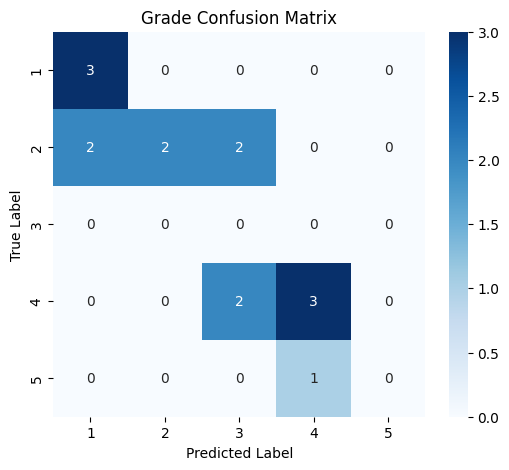

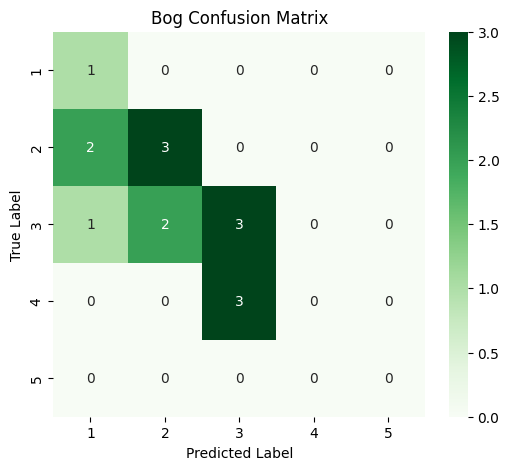

In [301]:
# grade confusion matrix
grade_cm = confusion_matrix(all_grade_labels, all_grade_preds, labels=[0,1,2,3,4])
plt.figure(figsize=(6, 5))
sns.heatmap(grade_cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title("Grade Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# bog confusion matrix
bog_cm = confusion_matrix(all_bog_labels, all_bog_preds, labels=[0,1,2,3,4])
plt.figure(figsize=(6, 5))
sns.heatmap(bog_cm, annot=True, fmt="d", cmap="Greens", xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title("Bog Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [289]:
# Show first 20 predictions
for i in range(20):
    print(f"Example {i+1}: Grade - True: {all_grade_labels[i]+1}, Pred: {all_grade_preds[i]+1} | Bog - True: {all_bog_labels[i]+1}, Pred: {all_bog_preds[i]+1}")


Example 1: Grade - True: 1, Pred: 1 | Bog - True: 1, Pred: 1
Example 2: Grade - True: 2, Pred: 2 | Bog - True: 3, Pred: 2
Example 3: Grade - True: 2, Pred: 2 | Bog - True: 2, Pred: 2
Example 4: Grade - True: 4, Pred: 4 | Bog - True: 3, Pred: 3
Example 5: Grade - True: 2, Pred: 3 | Bog - True: 2, Pred: 2
Example 6: Grade - True: 2, Pred: 2 | Bog - True: 3, Pred: 2
Example 7: Grade - True: 4, Pred: 3 | Bog - True: 4, Pred: 3
Example 8: Grade - True: 4, Pred: 4 | Bog - True: 4, Pred: 3
Example 9: Grade - True: 2, Pred: 1 | Bog - True: 2, Pred: 1
Example 10: Grade - True: 1, Pred: 1 | Bog - True: 3, Pred: 1
Example 11: Grade - True: 1, Pred: 1 | Bog - True: 2, Pred: 1
Example 12: Grade - True: 4, Pred: 4 | Bog - True: 4, Pred: 3
Example 13: Grade - True: 4, Pred: 4 | Bog - True: 3, Pred: 3
Example 14: Grade - True: 2, Pred: 1 | Bog - True: 2, Pred: 2
Example 15: Grade - True: 5, Pred: 4 | Bog - True: 3, Pred: 3


IndexError: list index out of range